In [1]:
import lifelines
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import LabelEncoder
from IPython.display import Markdown as md
from lifelines import CoxPHFitter
from lifelines import AalenJohansenFitter
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
import multiprocessing
from scipy import interpolate  # Import for interpolation


import warnings;
warnings.filterwarnings('ignore');


In [2]:
data = pd.read_csv('racat_prep.csv')

## CATE from weighted KM

In [3]:
atb = (data['Antibiotic']==1)
T = data['T'].copy()
E = data['Ea'].copy()

In [4]:
def logit_ip_weights(y, X):
    """
    Create IP weights from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of IP weights
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = res.predict(X.loc[y == 1])
    weights[y == 0] = 1 - res.predict(X.loc[y == 0])
    return weights

In [5]:
data_ip = data[["edat", "any_qx", "bmi_val", "charlindex", "codisexe", "nivah", "Diabetes", "Obesitat", "Rheumatoid_Arthritis", "smoking_value", "Durada_intervencio_minuts", "viscositat", "Alcohol_Abuse"]]

In [6]:
pd.factorize(data.nivah)

(array([0, 1, 2, ..., 3, 1, 0]),
 Index(['X3', 'X1', 'X2', 'X4', 'X4a'], dtype='object'))

In [7]:
pd.factorize(data.viscositat)

(array([0, 1, 0, ..., 3, 3, 0]),
 Index(['Alta', 'nc', 'Baixa', 'Mitja'], dtype='object'))

In [8]:
pd.factorize(data.viscositat)[0]

array([0, 1, 0, ..., 3, 3, 0])

In [9]:
data_ip['nivah_int'] = pd.factorize(data.nivah)[0]
data_ip['viscositat_int'] = pd.factorize(data.viscositat)[0]

In [10]:
data_ip.drop(['nivah','viscositat'],axis=1,inplace=True)

In [11]:
data_ip

,edat,any_qx,bmi_val,charlindex,codisexe,Diabetes,Obesitat,Rheumatoid_Arthritis,smoking_value,Durada_intervencio_minuts,Alcohol_Abuse,nivah_int,viscositat_int
0,72.747437,2018,30.67,0,1,0,1.0,0.0,0.0,89.912115,0.0,0,0
1,78.365501,2019,30.73,1,1,0,0.0,0.0,2.0,106.000000,0.0,1,1
2,83.101982,2019,31.05,1,1,1,0.0,0.0,0.0,74.000000,0.0,2,0
3,75.186859,2020,26.92,0,1,0,0.0,0.0,0.0,89.912115,0.0,3,2
4,71.904175,2020,41.33,0,1,0,1.0,0.0,2.0,89.912115,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22776,76.210815,2020,32.76,0,1,0,0.0,0.0,0.0,89.912115,0.0,3,0
22777,78.965096,2020,34.74,0,1,0,0.0,0.0,0.0,89.912115,0.0,1,3
22778,73.388092,2020,40.74,3,1,0,1.0,0.0,2.0,132.000000,0.0,3,3
22779,64.312119,2020,35.19,1,0,1,0.0,0.0,2.0,89.912115,0.0,1,3


In [12]:
X = data_ip

In [13]:
ip_denom = logit_ip_weights(data.Antibiotic, X)

Optimization terminated successfully.
         Current function value: 0.670221
         Iterations 4


In [14]:
pr_antibiotic = data.Antibiotic.mean()

ip_numer = np.zeros(ip_denom.shape[0])
ip_numer[data.Antibiotic == 0] = 1 - pr_antibiotic
ip_numer[data.Antibiotic == 1] = pr_antibiotic

In [15]:
ip_weights = ip_numer / ip_denom

In [16]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    ip_weights.min(),
    ip_weights.mean(),
    ip_weights.max()
))

Stabilized weights
 min   mean    max
------------------
0.61   1.00   2.25


In [17]:
dm = data[data.Obesitat==1].index
n_dm = data[data.Obesitat==0].index

In [18]:
atb = data[data.Antibiotic==1].index
n_atb = data[data.Antibiotic==0].index

In [19]:
kmf = KaplanMeierFitter()

# ATB, Diabetes
kmf.fit(T[atb.intersection(dm)],E[atb.intersection(dm)], label='w_atb_w_dm', weights=ip_weights[atb.intersection(dm)])
survival_w_atb_w_dm = kmf.survival_function_
survival_w_atb_w_dm_ci = kmf.confidence_interval_survival_function_

# No ATB, Diabetes
kmf.fit(T[n_atb.intersection(dm)],E[n_atb.intersection(dm)], label='wo_atb_w_dm', weights=ip_weights[n_atb.intersection(dm)])
survival_wo_atb_w_dm = kmf.survival_function_
survival_wo_atb_w_dm_ci = kmf.confidence_interval_survival_function_

# ATB, No diabetes
kmf.fit(T[atb.intersection(n_dm)],E[atb.intersection(n_dm)], label='w_atb_wo_dm', weights=ip_weights[atb.intersection(n_dm)])
survival_w_atb_wo_dm = kmf.survival_function_
survival_w_atb_wo_dm_ci = kmf.confidence_interval_survival_function_

# No ATB, No diabetes
kmf.fit(T[n_atb.intersection(n_dm)],E[n_atb.intersection(n_dm)], label='wo_atb_wo_dm', weights=ip_weights[n_atb.intersection(n_dm)])
survival_wo_atb_wo_dm = kmf.survival_function_
survival_wo_atb_wo_dm_ci = kmf.confidence_interval_survival_function_


In [20]:
diff_w_dm = survival_w_atb_w_dm['w_atb_w_dm'] - survival_wo_atb_w_dm['wo_atb_w_dm']

In [21]:
diff_wo_dm = survival_w_atb_wo_dm['w_atb_wo_dm'] - survival_wo_atb_wo_dm['wo_atb_wo_dm']

In [22]:
diff_w_dm_ci_up = survival_w_atb_w_dm_ci['w_atb_w_dm_upper_0.95'] - survival_wo_atb_w_dm_ci['wo_atb_w_dm_upper_0.95']

In [23]:
diff_w_dm_ci_lo = survival_w_atb_w_dm_ci['w_atb_w_dm_lower_0.95'] - survival_wo_atb_w_dm_ci['wo_atb_w_dm_lower_0.95']

In [24]:
diff_w_dm = diff_w_dm.dropna()

In [25]:
diff_wo_dm = diff_wo_dm.dropna()

In [26]:
diff_w_dm_ci_up = diff_w_dm_ci_up.dropna()

In [27]:
diff_w_dm_ci_lo = diff_w_dm_ci_lo.dropna()

## CATE from modelling the outcome

In [28]:
def survival_curve(hazard):
    survival = [1 - hazard[0]]
    for i in range(1, len(hazard)):
        survival.append((1 - hazard[i]) * survival[i - 1])
    return survival

In [29]:
def person_time_format(data, event_of_interest):
    # This works for the current data only; it requires the data
    # have `longevity` and `death` columns.

    # accumulate rows in a dict, then convert the dict to DataFrame;
    # the dict will contain each column of the input data, plus
    # `time`, which keeps track of month within individual, and
    # `event`, a 0/1 indicator of death for each month
    newrows = {name: [] for name in data.columns}
    newrows.update({'time': [], 'event': []})
    
    for _, row in data.iterrows():
        # n_mos: a zero for each month of `longevity`
        # and then a zero/one to indicate death afterwards
        n_mos = int(row['T'] + row[event_of_interest])
        for name in data.columns:
            newrows[name].extend([row[name]] * n_mos)
        newrows['time'].extend(range(n_mos))
        newrows['event'].extend([0] * n_mos)
        if row[event_of_interest]:
            newrows['event'][-1] = 1

    return pd.DataFrame(newrows)

In [30]:
pt_data_a = person_time_format(data, 'Ea')

In [31]:
model_a = sm.Poisson.from_formula(
    #'event ~ Antibiotic + Antibiotic:time + Antibiotic:np.power(time, 2) + Antibiotic:np.power(time, 3) + Antibiotic:np.power(time, 4) + time + np.power(time, 2) + np.power(time, 3) + np.power(time, 4)',
    #'event ~ Antibiotic + Antibiotic:time + Antibiotic:np.power(time, 2) + Antibiotic:np.power(time, 3) + time + np.power(time, 2) + np.power(time, 3)',
    'event ~ C(Antibiotic) + C(Antibiotic):time + C(Antibiotic):np.power(time, 2) + C(Obesitat)',
    data=pt_data_a
)

In [32]:
res_a = model_a.fit()

Optimization terminated successfully.
         Current function value: 0.009340
         Iterations 26


In [33]:
res_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                  event   No. Observations:              1895898
Model:                        Poisson   Df Residuals:                  1895891
Method:                           MLE   Df Model:                            6
Date:                Sun, 02 Jun 2024   Pseudo R-squ.:                 0.01244
Time:                        13:53:22   Log-Likelihood:                -17708.
converged:                       True   LL-Null:                       -17931.
Covariance Type:            nonrobust   LLR p-value:                 3.272e-93
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -6.0131      0.060    -99.610      0.000      -6.131      -5.895
C(Antibiotic)[T.1]                    -0.2254      0.086     -2.615      0.009      -0.394      -0.056
C(Obesitat)[T.1.0]                     0.2597      0.059      4.397      0.000       0.144       0.375
C(Antibiotic)[0]:time                 -0.0135      0.003     -5.304      0.000      -0.019      -0.009
C(Antibiotic)[1]:time                 -0.0326      0.003    -11.339      0.000      -0.038      -0.027
C(Antibiotic)[0]:np.power(time, 2)  5.093e-05   2.13e-05      2.391      0.017    9.18e-06    9.27e-05
C(Antibiotic)[1]:np.power(time, 2)     0.0002   2.38e-05      8.600      0.000       0.000       0.000
======================================================================================================
"""

In [34]:
ATB0_ob_pred = res_a.predict(
    pd.DataFrame({'time': list(range(160)), 'Antibiotic': [0] * 160, 'Obesitat': [1] * 160})
)
ATB1_ob_pred = res_a.predict(
    pd.DataFrame({'time': list(range(160)), 'Antibiotic': [1] * 160, 'Obesitat': [1] * 160})
)

ATB0_nob_pred = res_a.predict(
    pd.DataFrame({'time': list(range(160)), 'Antibiotic': [0] * 160, 'Obesitat': [0] * 160})
)
ATB1_nob_pred = res_a.predict(
    pd.DataFrame({'time': list(range(160)), 'Antibiotic': [1] * 160, 'Obesitat': [0] * 160})
)

In [35]:
model_surv_atb0_ob_all = survival_curve(ATB0_ob_pred)
model_surv_atb1_ob_all = survival_curve(ATB1_ob_pred)

model_surv_atb0_nob_all = survival_curve(ATB0_nob_pred)
model_surv_atb1_nob_all = survival_curve(ATB1_nob_pred)

In [36]:
ob = np.array(model_surv_atb1_ob_all) - np.array(model_surv_atb0_ob_all)

In [37]:
nob = np.array(model_surv_atb1_nob_all) - np.array(model_surv_atb0_nob_all)

## CATE from CSF

In [58]:
eti='Ea'

In [64]:
data_obes = pd.read_csv("Causal_Survival_R/covariate_analysis/results_{}_wci/ate_matrix_Obesitat_{}.csv".format(eti, eti))

In [66]:
data_obes.drop(['Unnamed: 0','0'], axis=1, inplace=True)

In [69]:
ate = data_obes.loc[1,data_obes.columns[0:]].apply(lambda x: x.split(';')[0],)
ate_std = data_obes.loc[1,data_obes.columns[0:]].apply(lambda x: x.split(';')[1],)

# All together

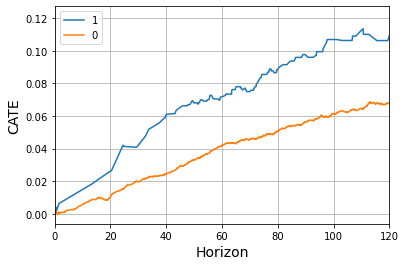

In [44]:
fig1, ax1 = plt.subplots()

ax1.plot(diff_w_dm)
ax1.plot(diff_wo_dm)

ax1.set_xlim(0,120)
ax1.set_xlabel('Horizon', fontsize=14)
ax1.set_ylabel('CATE', fontsize=14)
ax1.legend(['1', '0'])
plt.grid(True)

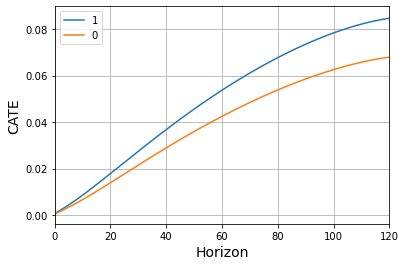

In [45]:
fig2, ax2 = plt.subplots()

ax2.plot(ob)
ax2.plot(nob)

ax2.set_xlim(0,120);
ax2.set_xlabel('Horizon', fontsize=14)
ax2.set_ylabel('CATE', fontsize=14)
ax2.legend(['1', '0'])
plt.grid(True)

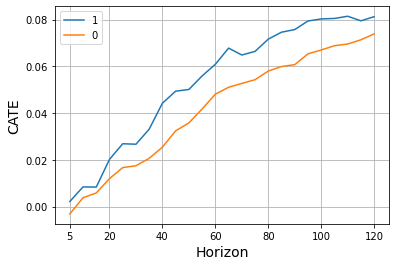

In [46]:
fig3, ax3 = plt.subplots()

ax3.plot(data_obes.columns.values, data_obes.iloc[1,:].values)
ax3.plot(data_obes.columns.values, data_obes.iloc[0,:].values)

plt.xticks([0,3,7,11,15,19,23])
ax3.set_xlabel('Horizon', fontsize=14)
ax3.set_ylabel('CATE', fontsize=14)
ax3.legend(['1', '0'])
plt.grid(True)

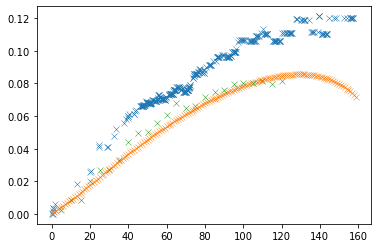

In [47]:
fig4, ax4 = plt.subplots()

ax4.scatter(diff_w_dm.index.values, diff_w_dm.values, marker='x', linewidths=0.5)
ax4.scatter(range(0,len(ob)), ob, marker='x', linewidths=0.5)
ax4.scatter(pd.to_numeric(data_obes.columns.values), data_obes.iloc[1,:].values, marker='x', linewidths=0.5)


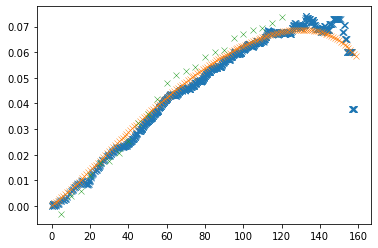

In [48]:
fig5, ax5 = plt.subplots()

ax5.scatter(diff_wo_dm.index.values, diff_wo_dm.values, marker='x', linewidths=0.5)
ax5.scatter(range(0,len(nob)), nob, marker='x', linewidths=0.5)
ax5.scatter(pd.to_numeric(data_obes.columns.values), data_obes.iloc[0,:].values, marker='x', linewidths=0.5)

In [88]:
plt.close()

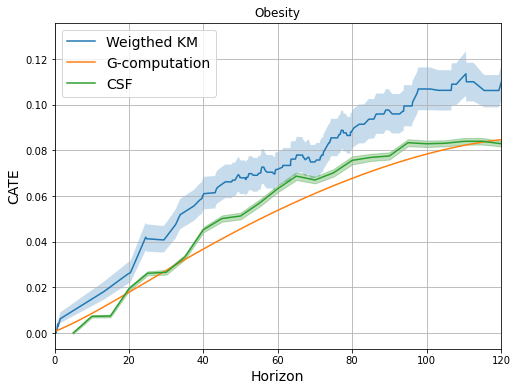

In [91]:
fig4 = plt.figure(figsize=(8,6))
ax4 = fig4.add_subplot(111)

#fig4, ax4 = plt.subplots()

ax4.plot(diff_w_dm.index.values, diff_w_dm.values)
plt.fill_between(diff_w_dm.index.values, diff_w_dm_ci_lo, diff_w_dm_ci_up, alpha=0.25)

ax4.plot(range(0,len(ob)), ob)

ax4.plot(pd.to_numeric(ate.index.values), pd.to_numeric(ate.values))
plt.fill_between(pd.to_numeric(ate.index.values), pd.to_numeric(ate.values)-1.96*pd.to_numeric(ate_std.values), pd.to_numeric(ate.values)+1.96*pd.to_numeric(ate_std.values), alpha=0.25, color='green')

ax4.set_xlim(0,120);
ax4.set_xlabel('Horizon', fontsize=14)
ax4.set_ylabel('CATE', fontsize=14)
ax4.set_title('Obesity')
ax4.legend(['Weigthed KM', 'G-computation', 'CSF'], fontsize=14)
plt.grid(True)
plt.savefig('method_comparison_plot.pdf')
plt.show()

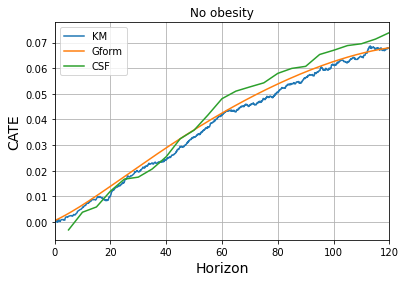

In [73]:
fig5, ax5 = plt.subplots()

ax5.plot(diff_wo_dm.index.values, diff_wo_dm.values)
ax5.plot(range(0,len(nob)), nob)
ax5.plot(pd.to_numeric(data_obes.columns.values), data_obes.iloc[0,:].values)
ax5.set_xlim(0,120);
ax5.set_xlabel('Horizon', fontsize=14)
ax5.set_ylabel('CATE', fontsize=14)
ax5.set_title('No obesity')
ax5.legend(['KM', 'Gform', 'CSF'])
plt.grid(True)